# Analise descritiva

## Carregar dados tratados

In [21]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [22]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

import joblib

In [23]:
def carregar_joblib():
    df = joblib.load("../out/tratamento_target.joblib")
    return df

In [24]:
def print_histograma_comprar_vender(df):
    df['decisao'].value_counts(normalize=True).map("{:.1%}".format)
    fig = px.histogram(df, x="decisao", color="decisao")
    fig.show()

In [25]:
def print_correlacoes(df):
    correlacoes = df.corr()

    print(correlacoes)

    print(df.describe())

    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(correlacoes, cmap="Wistia", ax=ax)
    plt.show()

In [26]:
def remover_variaveis_ja_explicadas(df):
    # remover = ["RPL", "RA", "AF"]
    # remover = ["RPL", "RA"] # LogReg
    # remover = ["RPL", "RA", "AF", "GA"] # RN
    remover = ["RPL", "RA", "part_cap_terceiros"] # RN
    df = df.drop(remover, axis=1)

    return df

## P value

In [27]:
def print_p_value(df):
    all_col = " + ".join(df.drop("decisao", axis=1).columns)
    model = smf.glm(formula="decisao ~ " + all_col, data=df,
                    family = sm.families.Binomial()).fit()

    print(model.summary()) 

## Feature selection

In [28]:
def print_feature_selection_extra_trees(df):
    modelo = ExtraTreesClassifier(random_state=1)
    x = df.drop("decisao", axis=1)
    y = df["decisao"]
    modelo.fit(x, y)

    caracteristicas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
    print(caracteristicas_importantes)

In [29]:
def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = tabela_original["decisao"]
    
    return tabela_auxiliar


In [35]:
def salvar_df_in_joblib(df, file_name: str = "../out/result_analise_desc.joblib"):

    joblib.dump(df, file_name)

    print("arquivo joblib de df analise descritiva criado com sucesso")


# Execucao

                           RPL       ROE        AF        RA  \
RPL                   1.000000  1.000000 -0.025066  0.994031   
ROE                   1.000000  1.000000 -0.025066  0.994031   
AF                   -0.025066 -0.025066  1.000000 -0.025523   
RA                    0.994031  0.994031 -0.025523  1.000000   
part_cap_terceiros   -0.045429 -0.045429  0.945119 -0.046745   
comp_endividamento   -0.009604 -0.009604  0.008330 -0.008514   
imob_patrimonio_liq  -0.001824 -0.001824  0.681161 -0.001660   
imob_recursos_n_corr  0.020763  0.020763  0.023805  0.022083   
liq_corrente          0.132985  0.132985 -0.080729  0.132860   
decisao               0.017731  0.017731 -0.051701  0.018687   

                      part_cap_terceiros  comp_endividamento  \
RPL                            -0.045429           -0.009604   
ROE                            -0.045429           -0.009604   
AF                              0.945119            0.008330   
RA                             -0.04674

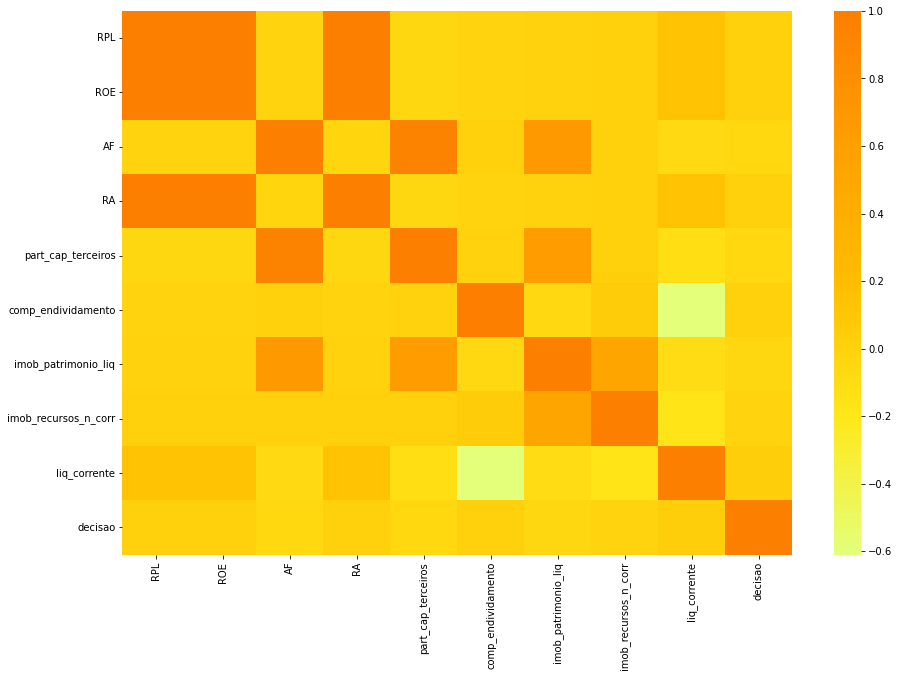

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning:

overflow encountered in exp

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1014: RuntimeWarning:

divide by zero encountered in log

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1014: RuntimeWarning:

invalid value encountered in multiply



                 Generalized Linear Model Regression Results                  
Dep. Variable:                decisao   No. Observations:                 1667
Model:                            GLM   Df Residuals:                     1658
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 13 Oct 2021   Deviance:                       76077.
Time:                        19:40:15   Pearson chi2:                 3.72e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.594e+15 

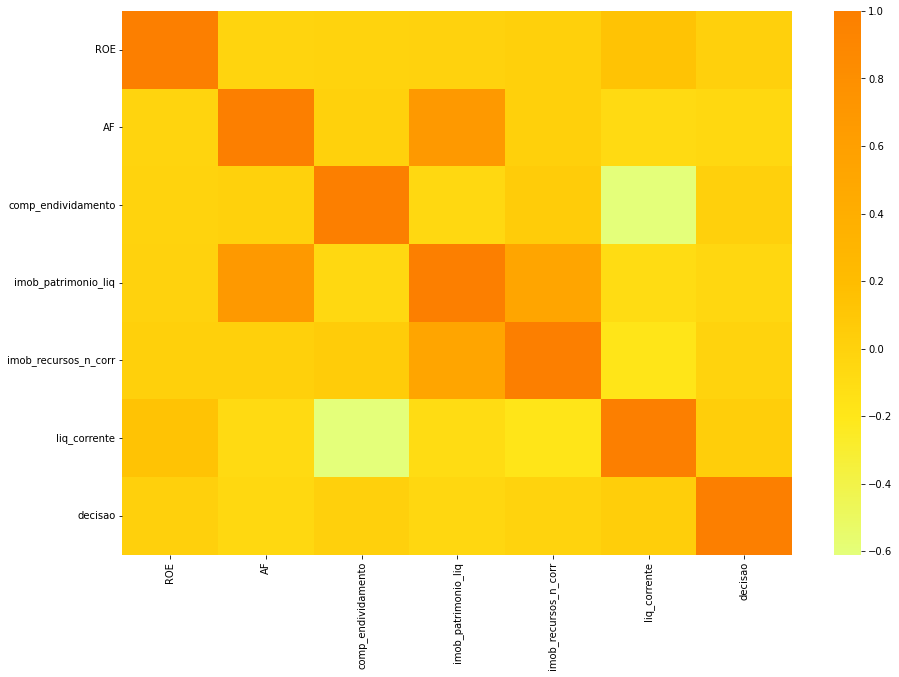

                 Generalized Linear Model Regression Results                  
Dep. Variable:                decisao   No. Observations:                 1667
Model:                            GLM   Df Residuals:                     1660
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1150.5
Date:                Wed, 13 Oct 2021   Deviance:                       2301.0
Time:                        19:40:15   Pearson chi2:                 1.67e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.005897
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0227 

In [37]:
def main():
    df = carregar_joblib()

    print_histograma_comprar_vender(df)

    print_correlacoes(df)

    print_p_value(df)

    df = remover_variaveis_ja_explicadas(df)

    print("Correlacoes apos remover algumas colunas")

    print_correlacoes(df)

    print_p_value(df)

    print(df.shape)

    print("Feature Selection")

    print_feature_selection_extra_trees(df)

    scaled_df = ajustar_scaler(df)

    salvar_df_in_joblib(scaled_df)

    
main()

## Escolha de 3 melhores modelos para comparação

In [ ]:
modelo_final = modelos["RandomForest"]

n_estimators = range(10, 251, 30)
max_features = list()
max_features.append('auto')

precision2_score = make_scorer(precision_score, labels=[2], average='macro')

grid = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'n_estimators': n_estimators,
            'max_features': max_features,
            'random_state': [1],
        },
        scoring=precision2_score,
)

resultado_grid = grid.fit(X_treino, y_treino)
print("Ajuste feito")

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicte

Ajuste feito


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



RandomForest Tunado
Reporte teste
              precision    recall  f1-score   support

           0       0.53      0.63      0.57       250
           1       0.54      0.44      0.48       251

    accuracy                           0.53       501
   macro avg       0.53      0.53      0.53       501
weighted avg       0.53      0.53      0.53       501



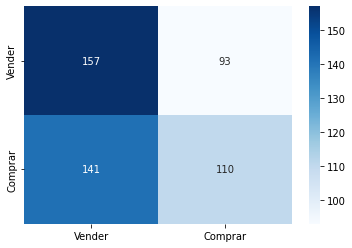

##################################################


In [ ]:
modelo_tunado = resultado_grid.best_estimator_
previsoes = modelo_tunado.predict(X_teste)
avaliar(y_teste, previsoes, "RandomForest Tunado")